In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN
!git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Mask_RCNN
!python setup.py install

/content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcn

In [ ]:
!pip show mask-rcnn

In [ ]:
!pip install tensorflow==1.15.3
!pip install h5py==2.10.0
!pip install tensorflow-gpu==1.15.3
!pip install -U scikit-image==0.16.2
!pip install keras==2.1.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import matplotlib.pyplot as plt
from mrcnn.visualize import display_instances

In [ ]:
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Mask_RCNN")
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.visualize import display_instances
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [ ]:
class CustomConfig(Config):
    GPU_COUNT = 2
    NAME = "object"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1 
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
class FootballDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "Ball")
       
        assert subset in ["train", "valid"]

        dataset_dir = os.path.join(dataset_dir, subset)
        annotations_temp = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        annotations = list(annotations_temp.values()) 
        annotations = [a for a in annotations if a['regions']]
        

        for a in annotations:
            polygons=[]
            objects=[]
            temp_1 = a['regions'].values()
            for temp_2 in temp_1:
              polygons.append(temp_2['shape_attributes'])
              objects.append(temp_2['region_attributes']['label'])

            num_ids = [1 for a in objects]
            image_path = os.path.join(dataset_dir, a['filename'])
            image = cv2.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  
                image_id=a['filename'],  
                path=image_path,
                width=width+1, height=height+1,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]

        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
      
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids 

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
def train(model):
    dataset_train = FootballDataset()
    dataset_train.load_custom("/content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Datasets", "train")
    dataset_train.prepare()

    dataset_val = FootballDataset()
    dataset_val.load_custom("/content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Datasets", "valid")
    dataset_val.prepare()

    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=5,
                layers='heads')

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

model.load_weights(COCO_WEIGHTS_PATH , by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.








In [ ]:
train(model)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Mask_RCNN/logs/object20221012T0827/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistribu

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2080: UserWarning: Using a generator with `use_multiproces

Epoch 1/5
 99/100 [============================>.] - ETA: 16s - loss: 0.8762 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0699 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.3089 - mrcnn_mask_loss: 0.4563

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 1834s 18s/step - loss: 0.8728 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.4535 - val_loss: 0.5743 - val_rpn_class_loss: 0.0070 - val_rpn_bbox_loss: 0.1397 - val_mrcnn_class_loss: 0.0112 - val_mrcnn_bbox_loss: 0.2317 - val_mrcnn_mask_loss: 0.1848


Epoch 2/5
100/100 [==============================] - 1816s 18s/step - loss: 0.2545 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1259 - val_loss: 0.4441 - val_rpn_class_loss: 0.0041 - val_rpn_bbox_loss: 0.0815 - val_mrcnn_class_loss: 0.0127 - val_mrcnn_bbox_loss: 0.1627 - val_mrcnn_mask_loss: 0.1830
Epoch 3/5
100/100 [==============================] - 1822s 18s/step - loss: 0.1764 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0968 - val_loss: 0.3939 - val_rpn_class_loss: 0.0030 - val_rpn_bbox_loss: 0.0979 - val_mrcnn_class_loss: 0.0108 - val_mrcnn_bbox_loss: 0.1048 - val_mrcnn_mask_loss: 0.1775
Epoch 4/5
100/100 [==============================] - 1815s 18s/step - loss: 0.1500 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.0872 - val_loss: 0.4145 - val_rpn_clas

Process Process-9:
Process Process-4:
Process Process-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "

KeyboardInterrupt: ignored

In [ ]:
def get_ax(rows=1, cols=1, size=30):
  "Return a Matplotlib Axes array to be used in all visualizations in the notebook. Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

In [ ]:
class InferenceConfig(config.__class__):
  # Run detection on one image at a time
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.7
config = InferenceConfig()

In [ ]:
model = modellib.MaskRCNN(mode="inference", model_dir='/content/drive/MyDrive/Mask_RCNN/logs', config=config)


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
model.load_weights('/content/drive/MyDrive/Mask_RCNN/logs/object20221002T1951/mask_rcnn_object_0002.h5', by_name=True)

Re-starting from epoch 2


In [ ]:
dataset = FootballDataset()
dataset.load_custom("/content/drive/MyDrive/Football", "valid")
dataset.prepare()

1
Processing 1 images
image                    shape: (194, 259, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[1]


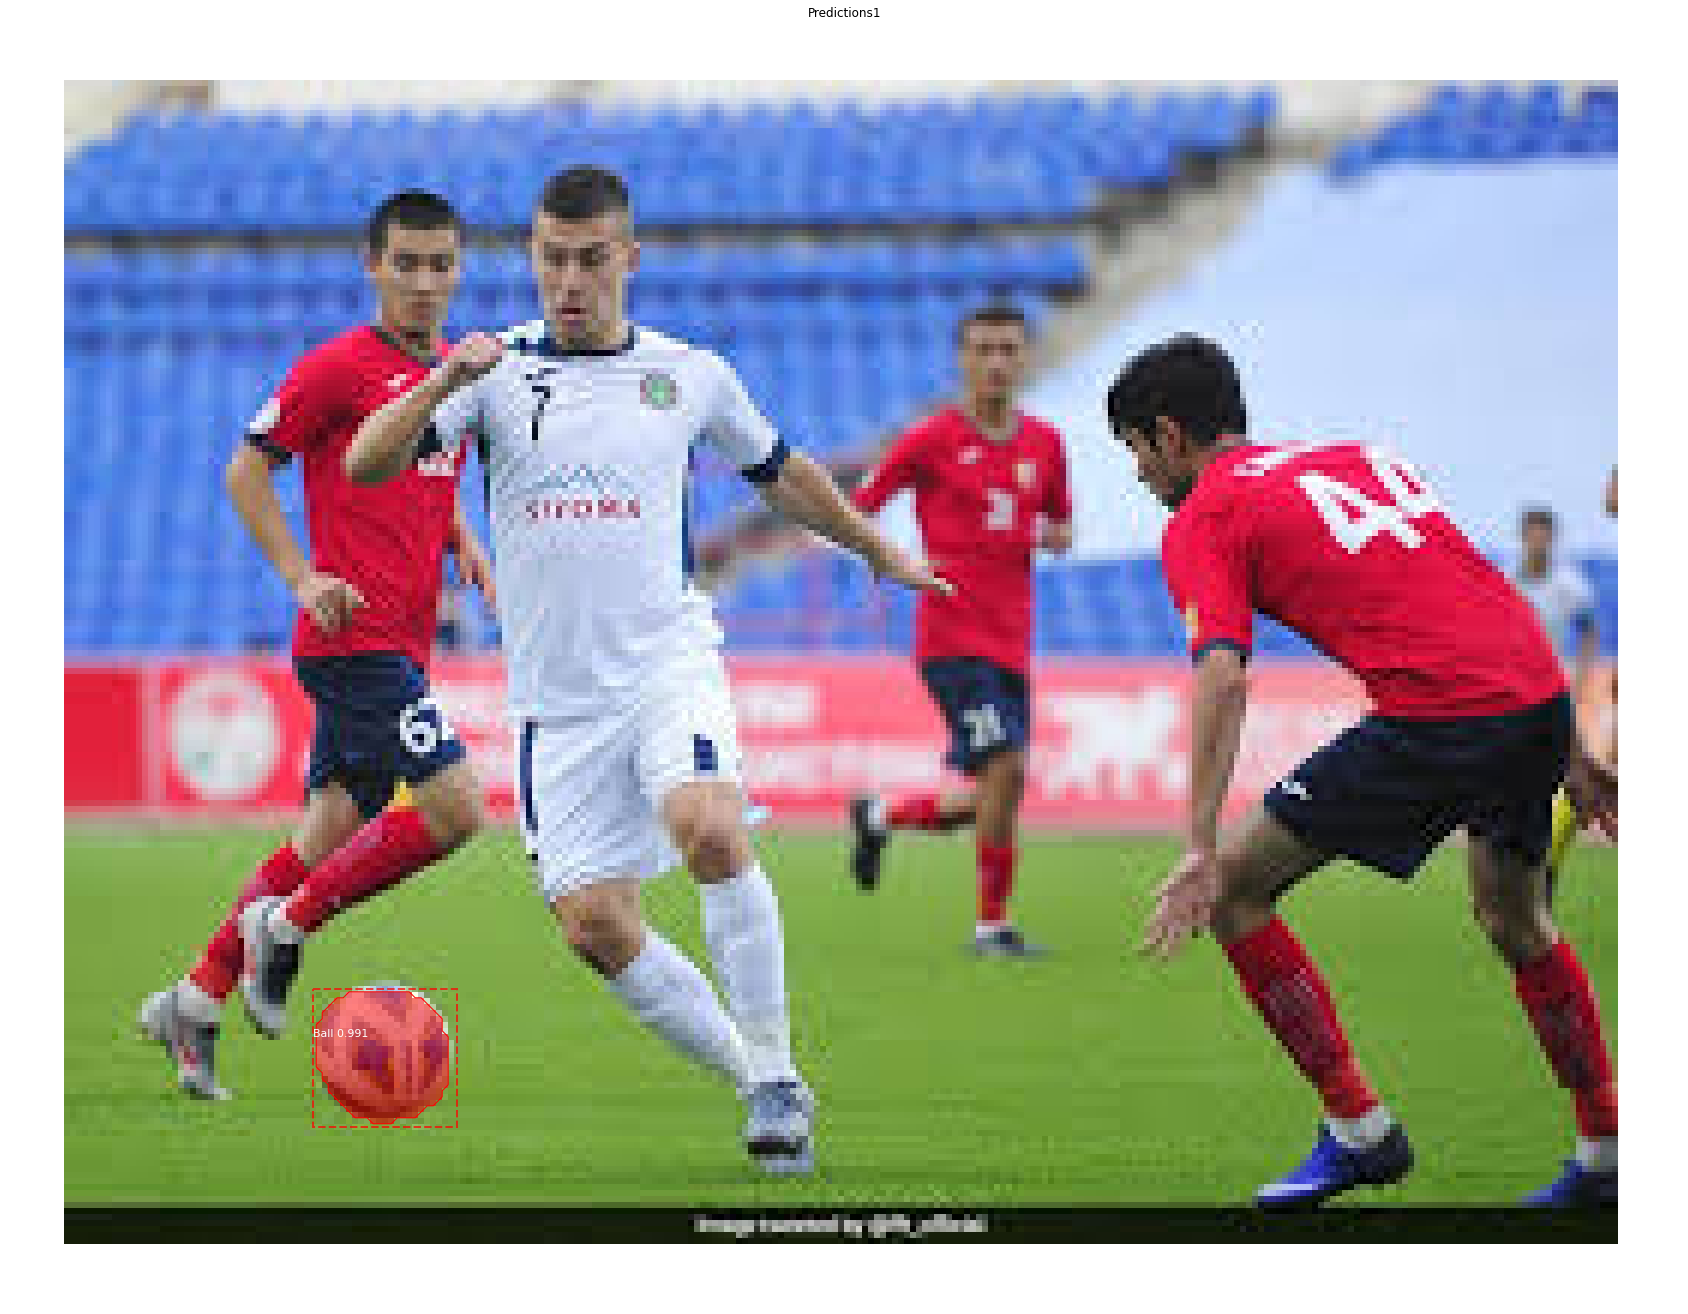

In [ ]:
import matplotlib.image as mpimg
image1 = mpimg.imread('/content/drive/MyDrive/Football/test/60.jpeg')
# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)
# Display results
ax = get_ax(1)
r1 = results1[0]
print(r1['class_ids'])
display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],dataset.class_names,
                  r1['scores'], ax=ax, title="Predictions1")